In [1]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

from keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dir = "/content/drive/MyDrive/Emojiclassification/train" # Directory containing the training data
test_dir = "/content/drive/MyDrive/Emojiclassification/test"  # Directory containing the validation data

In [4]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training"              # Uses the training subset of the data
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)

Found 5423 images belonging to 7 classes.
Found 640 images belonging to 7 classes.


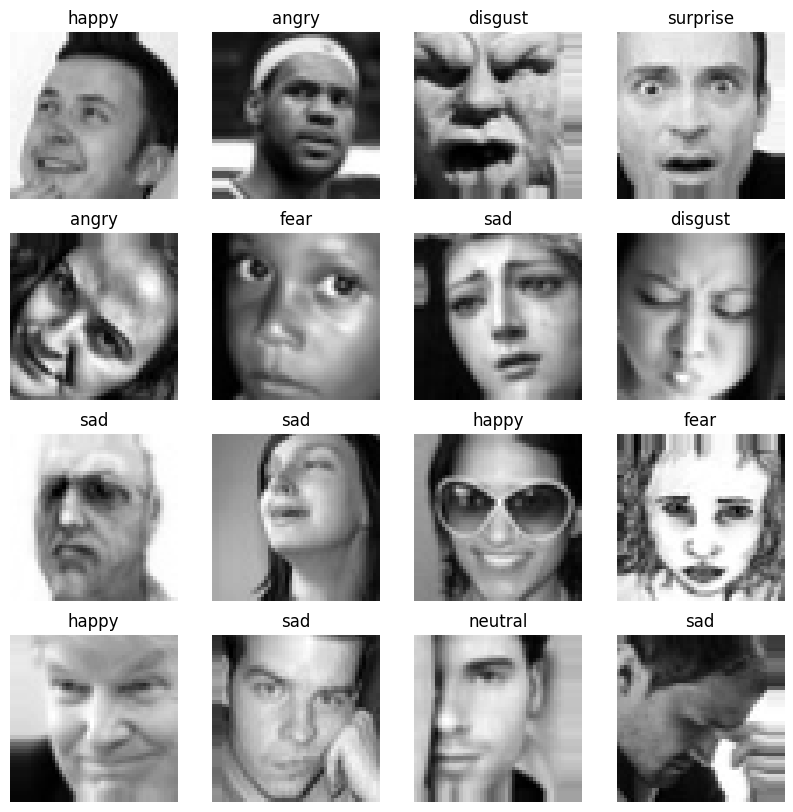

In [6]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the generator
batch = next(train_generator)

# Display the images in a 4x4 grid with their corresponding labels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i], cmap='gray') # display the image at index i of the batch on the current axis
    label_idx = batch[1][i].argmax() # get the index of the label for the image at index i of the batch
    label_map = {v:k for k,v in train_generator.class_indices.items()} # create a dictionary mapping the label index to the corresponding label name
    ax.set_title(label_map[label_idx]) # set the title of the current axis to the label name corresponding to the label index
    ax.axis('off') # turn off the axis ticks and labels

plt.show() # display the figure


In [7]:
model = tf.keras.Sequential([

        # input layer
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,1)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 1st hidden dense layer
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 2nd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 3rd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # Flatten layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        # output layer
        tf.keras.layers.Dense(7, activation='softmax')
    ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
optimiser = tf.keras.optimizers.Adam(learning_rate
                                     =0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 23, 23, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 23, 23, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 5, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,841,543 (14.65 MB)

 Trainable params: 3,837,575 (14.64 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [11]:
epochs = 100
batch_size = 64

In [12]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 1624s 17s/step - accuracy: 0.1496 - loss: 9.9180 - val_accuracy: 0.1594 - val_loss: 9.1444
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 229ms/step - accuracy: 0.1788 - loss: 9.5153 - val_accuracy: 0.2094 - val_loss: 9.0132
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.1873 - loss: 9.2847 - val_accuracy: 0.2266 - val_loss: 8.8714
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.1758 - loss: 9.0683 - val_accuracy: 0.2266 - val_loss: 8.6976
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.1836 - loss: 8.8436 - val_accuracy: 0.2172 - val_loss: 8.4515
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.2059 - loss: 8.5839 - val_accuracy: 0.1859 - val_loss: 8.3112
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.1880 - loss: 8.3979 - val_accuracy: 0.2000 - val_loss: 8.0166
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.1959 - loss: 8.1729 - val_accuracy

In [13]:
model.save('model_fer2013.h5')

In [14]:
# Generate generalization metrics
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.7407 - loss: 1.3530
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.5427 - loss: 2.0594
final train accuracy = 74.92 , validation accuracy = 52.34


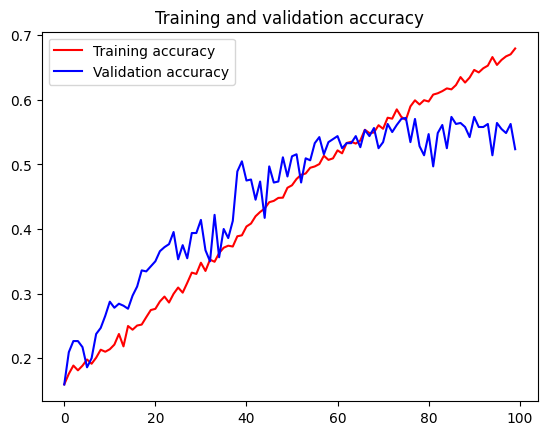

<Figure size 640x480 with 0 Axes>

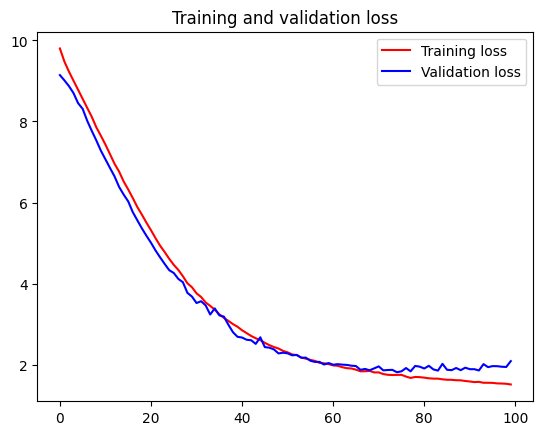

In [15]:
# Plot the train and validation loss
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

(48, 48)


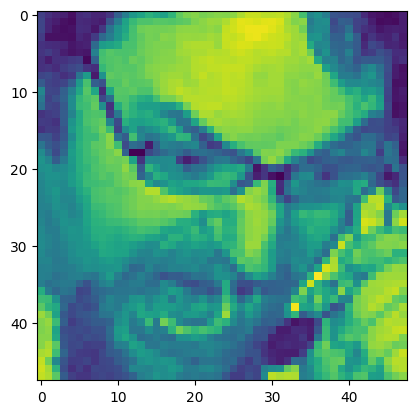

In [16]:
img = image.load_img("/content/drive/MyDrive/Emojiclassification/test/angry/PrivateTest_10131363.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [17]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [18]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[4.2139566e-19, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [19]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Disgust
